
Using the MNIST dataset to prepare the Tensorflow Developer Certification by Google.

---





#import libraries and data

In [1]:
#First step is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
from time import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

gEpochs = 100

print (tf.__version__)


2.8.2


In [2]:
# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
# Load the training and test split of the Fashion MNIST dataset
(x_train, y_train), (x_val, y_val) = fmnist.load_data()
# Normalize the pixel values of the train and test images
x_train  = x_train / 255.0
x_val = x_val / 255.0


4431872/4422102 [==============================] - 0s 0us/step


#functions

In [3]:

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [4]:
def plot_loss_acc_lr(history):
  rcParams['figure.figsize'] = (18, 8)
  rcParams['axes.spines.top'] = False
  rcParams['axes.spines.right'] = False 

  plt.plot(
      np.arange(1, 101), 
      history.history['loss'], 
      label='Loss', lw=3
  )
  plt.plot(
      np.arange(1, 101), 
      history.history['accuracy'], 
      label='Accuracy', lw=3
  )
  plt.plot(
      np.arange(1, 101), 
      history.history['lr'], 
      label='Learning rate', color='#000', lw=3, linestyle='--'
  )
  plt.title('Evaluation metrics', size=20)
  plt.xlabel('Epoch', size=14)
  plt.legend(); 

In [57]:
def show_img_dataset(nrows = 4, ncols=4, firstimg=100, numimg=4):
  for i in range(numimg):
    sp = plt.subplot(nrows, ncols, i + 1)

    sp.axis('Off')
    plt.imshow(x_train[firstimg+i], cmap=plt.get_cmap('gray'))
    plt.show()

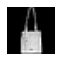

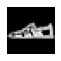

In [61]:
show_img_dataset(firstimg=200, numimg=2)

In [5]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.95:
                print("\nReached 95% val_accuracy so cancelling training!")               
                # Stop training once the above condition is met
                self.model.stop_training = True

callbacks = myCallback()

In [9]:
def get_model(kindmodel):
  default = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[28, 28, 1]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  switcher = {
      #First simple model, just to have a point where to start. 
      #we got a lot of overffiting with this model. 
      #100 epochs
      # 6s 3ms/step loss: 0.0575 - accuracy: 0.9788 - val_loss: 0.8411 - val_accuracy: 0.8788  
      0: tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[28, 28, 1]), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)]),
              
      #simple convolutional model just to apply some filters to the images       
      #a lot of overfitting too 
      #100 epochs. 
      # 9s 5ms/step - loss: 0.0277 - accuracy: 0.9920 - val_loss: 1.3412 - val_accuracy: 0.8906 
      #After Data Augmentation: 
      #100 epochs: 
      # 22s 47ms/step - loss: 0.2268 - accuracy: 0.9146 - val_loss: 0.3091 - val_accuracy: 0.8955
      1: tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')]), 
      #To avoid overfitting I'm going to add some dropout layers. and it works! 
      #The curve is realy nice, wiuth the samen numbers betewwen training and validating data 
      #100 epochs
      # 10s 5ms/step - loss: 0.2712 - accuracy: 0.9015 - val_loss: 0.2841 - val_accuracy: 0.8950   
      #After Data Augmentation: 
      #100 epochs: 
      # 22s 46ms/step - loss: 0.4052 - accuracy: 0.8544 - val_loss: 0.3293 - val_accuracy: 0.8794                     
      2: tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Dense(10, activation='softmax')]),
      #More powerful version of the model 2. With more filters in the Conv layers and a bigger dense layer.
      #100 epochs
      # 10s 5ms/step - loss: 0.2150 - accuracy: 0.9239 - val_loss: 0.3072 - val_accuracy: 0.8975
      #After Data Augmentation: 
      #100 epochs: 
      # 22s 47ms/step - loss: 0.3286 - accuracy: 0.8800 - val_loss: 0.2861 - val_accuracy: 0.8961
      21: tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Dense(10, activation='softmax')]),
      #Add more convolutional layers and mixing dropout with batchnormalization, and remove some MaxPooling to mantain more
      #100 eopochs
      # 10s 5ms/step - loss: 0.0867 - accuracy: 0.9692 - val_loss: 0.2542 - val_accuracy: 0.9327 
      # lr: 0.0016 
      # 10s 5ms/step - loss: 0.1545 - accuracy: 0.9470 - val_loss: 0.2455 - val_accuracy: 0.9283
      #After Data Augmentatiuon
      #100 epochs: 
      # 16s 35ms/step - loss: 0.1895 - accuracy: 0.9301 - val_loss: 0.2020 - val_accuracy: 0.9271
      22: tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    #tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.2),                                                                        
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')]),
      #This model is based in one that works really fine in Kaggle with MNIST dataset. 
      #Reference model 1. 
      #https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook
      #Author: CHRIS DEOTE
      #The accuracy is really good in both sets of data, but it have some signs of overfitting, i'm not sure about
      #how the model will work with more epochs. 
      #100 epochs: 
      # 14s 8ms/step - loss: 0.0466 - accuracy: 0.9837 - val_loss: 0.2819 - val_accuracy: 0.9350
      #After Data Augmentation: 
      #100 epochs: 
      # 23s 50ms/step - loss: 0.1745 - accuracy: 0.9359 - val_loss: 0.1891 - val_accuracy: 0.9322
      3: tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, (5,5), strides=2, activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.4),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(64, (5,5), strides=2, activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.4),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Dense(10, activation='softmax')]), 
              
        #another model adapted from Kaggle, in this ocassion a top 1%, by Kassem.
        #https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1
        #100 epochs
        # 10s 5ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.7954 - val_accuracy: 0.9231
        #After Data Augmentation: 
        #100 epochs:
        #  24s 52ms/step - loss: 0.0575 - accuracy: 0.9791 - val_loss: 0.3185 - val_accuracy: 0.9265       
        4: tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(28,28,1)), 
                                    tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"), 
                                    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
                                    tf.keras.layers.BatchNormalization(), 
                                    tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"), 
                                    tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"), 
                                    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
                                    tf.keras.layers.BatchNormalization(), 
                                    tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"), 
                                    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
                                    tf.keras.layers.BatchNormalization(), 
                                    tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(512,activation="relu"), 
                                    tf.keras.layers.Dense(10,activation="softmax")]), 
  }
  #return model
  return switcher.get(kindmodel, default)


#FIRST SIMPLE MODEL

In [11]:
# Build the classification model
model0 = get_model(0)
model0.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 
history0 = model0.fit(x_train, 
                        y_train, 
                        epochs=gEpochs, 
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)
# Compile the model


Epoch 1/100
1875/1875 [==============================] - 7s 2ms/step - loss: 0.4980 - accuracy: 0.8251 - val_loss: 0.4273 - val_accuracy: 0.8451
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3721 - accuracy: 0.8651 - val_loss: 0.4558 - val_accuracy: 0.8443
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3344 - accuracy: 0.8784 - val_loss: 0.3768 - val_accuracy: 0.8621
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3106 - accuracy: 0.8868 - val_loss: 0.3754 - val_accuracy: 0.8650
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2929 - accuracy: 0.8927 - val_loss: 0.3691 - val_accuracy: 0.8699
Epoch 6/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2788 - accuracy: 0.8968 - val_loss: 0.3804 - val_accuracy: 0.8646
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2690 - accuracy: 0.9000 - val_loss: 0.3657 - val_ac

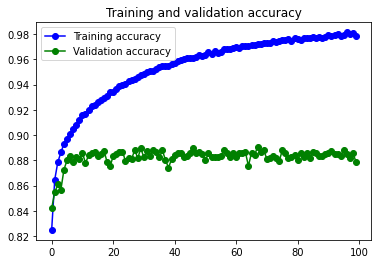

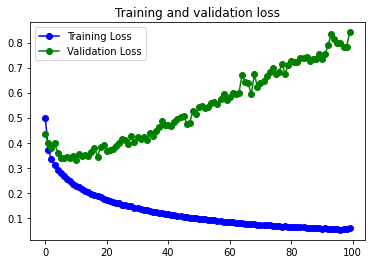

In [ ]:
plot_loss_acc(history0)

This first simple model accieve good numbers in loos and accuracy, but only eith the training data. We can observe that we have a lor of overfiting. 
When we test the model with validation data, the los is soi much big, and the accuracy is 10 points lower. 

#Convolutional Model 

In [ ]:
from tensorflow.python.ops.nn_ops import dropout
from tensorflow.keras.optimizers import RMSprop
# Define the model
model1 = get_model(1)
model1.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

In [ ]:
    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
    history1 = model1.fit(x_train, 
                        y_train, 
                        epochs=gEpochs, 
                        validation_data = (x_val, y_val),
                        callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5685 - accuracy: 0.7907 - val_loss: 0.4267 - val_accuracy: 0.8460
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3860 - accuracy: 0.8576 - val_loss: 0.4345 - val_accuracy: 0.8387
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3283 - accuracy: 0.8786 - val_loss: 0.3481 - val_accuracy: 0.8758
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2895 - accuracy: 0.8923 - val_loss: 0.3168 - val_accuracy: 0.8870
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2610 - accuracy: 0.9020 - val_loss: 0.3220 - val_accuracy: 0.8854
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2371 - accuracy: 0.9115 - val_loss: 0.3036 - val_accuracy: 0.8929
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2170 - accuracy: 0.9179 - val_loss: 0.3056 - val_a

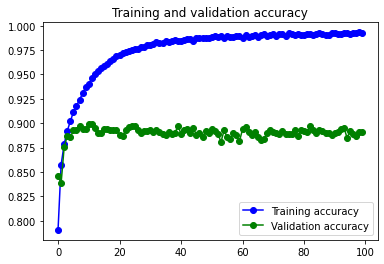

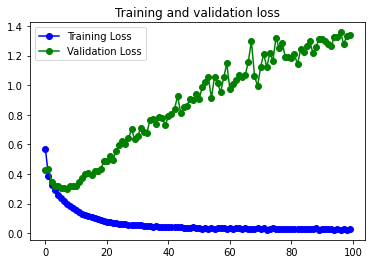

In [ ]:
plot_loss_acc(history1)

With convolutional model we get better numbers with the validate data than with the simpler model. 

**Validation data:**

-Loss: 02946

-Accuracy: 08959



**Training Data after 10 epochs:**

-Loss: 02496

-Accuracy: 08959

No sings of overffing, at last in this 10 epoch. 

#Convolutional Model with MaxPooling and Dropout to avoid overfitting

In [ ]:
from tensorflow.python.ops.nn_ops import dropout
# Build the classification model
model2 = get_model(2)

model2.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
history2 = model2.fit(x_train, 
                        y_train, 
                        epochs=gEpochs,
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)
    


Epoch 1/100
1875/1875 [==============================] - 9s 4ms/step - loss: 0.7638 - accuracy: 0.7180 - val_loss: 0.4987 - val_accuracy: 0.8175
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5214 - accuracy: 0.8118 - val_loss: 0.4393 - val_accuracy: 0.8416
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4571 - accuracy: 0.8354 - val_loss: 0.3950 - val_accuracy: 0.8481
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4237 - accuracy: 0.8478 - val_loss: 0.3601 - val_accuracy: 0.8701
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4012 - accuracy: 0.8537 - val_loss: 0.3553 - val_accuracy: 0.8686
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3895 - accuracy: 0.8590 - val_loss: 0.3384 - val_accuracy: 0.8724
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3769 - accuracy: 0.8624 - val_loss: 0.3323 - val_ac

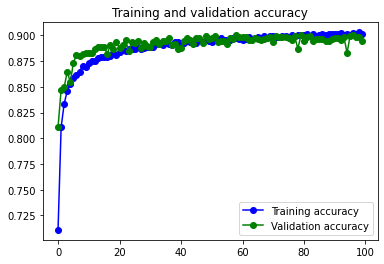

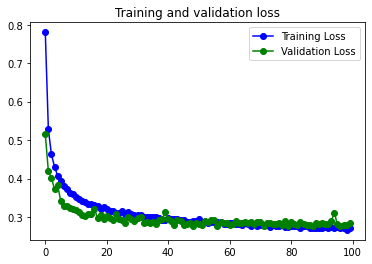

In [ ]:
plot_loss_acc(history2)

# Convolutional Model Powered 1


In [ ]:
from tensorflow.python.ops.nn_ops import dropout
# Build the classification model
model21 = get_model(21)

model21.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
history21 = model21.fit(x_train, 
                        y_train, 
                        epochs=gEpochs,
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 15s 7ms/step - loss: 0.6423 - accuracy: 0.7632 - val_loss: 0.4337 - val_accuracy: 0.8399
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4407 - accuracy: 0.8383 - val_loss: 0.3860 - val_accuracy: 0.8610
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3908 - accuracy: 0.8572 - val_loss: 0.3558 - val_accuracy: 0.8636
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3613 - accuracy: 0.8680 - val_loss: 0.3307 - val_accuracy: 0.8786
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3401 - accuracy: 0.8743 - val_loss: 0.3176 - val_accuracy: 0.8844
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3286 - accuracy: 0.8794 - val_loss: 0.3102 - val_accuracy: 0.8876
Epoch 7/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3200 - accuracy: 0.8824 - val_loss: 0.3077 -

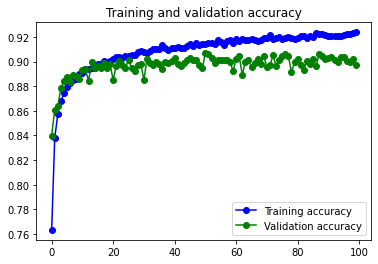

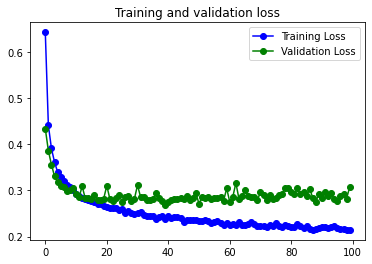

In [ ]:
plot_loss_acc(history21)

#Convolutional Model Powered 2. 

In [ ]:
from tensorflow.python.ops.nn_ops import dropout
# Build the classification model
model22 = get_model(22)

model22.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
history22 = model22.fit(x_train, 
                        y_train, 
                        epochs=gEpochs,
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 56s 5ms/step - loss: 0.5086 - accuracy: 0.8138 - val_loss: 0.3406 - val_accuracy: 0.8786
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3465 - accuracy: 0.8742 - val_loss: 0.3374 - val_accuracy: 0.8801
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3069 - accuracy: 0.8869 - val_loss: 0.3112 - val_accuracy: 0.8854
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2860 - accuracy: 0.8946 - val_loss: 0.2614 - val_accuracy: 0.9049
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2690 - accuracy: 0.9001 - val_loss: 0.2509 - val_accuracy: 0.9104
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2540 - accuracy: 0.9063 - val_loss: 0.2498 - val_accuracy: 0.9102
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2403 - accuracy: 0.9116 - val_loss: 0.2658 - va

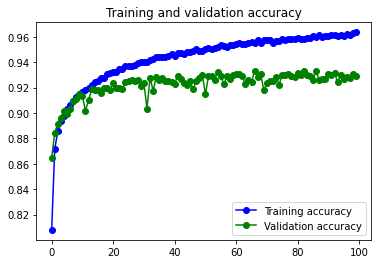

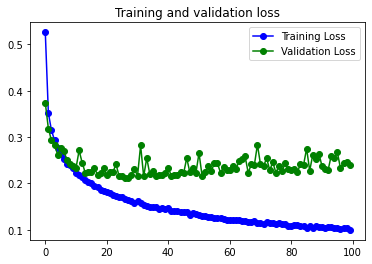

In [ ]:
plot_loss_acc(history22)

#Convolutional Model With BatchNormaliztion

In [ ]:
from tensorflow.python.ops.nn_ops import dropout
# Build the classification model
model3 = get_model(3)

model3.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
history3 = model3.fit(x_train, 
                        y_train, 
                        epochs=gEpochs, 
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.5506 - accuracy: 0.8014 - val_loss: 0.3388 - val_accuracy: 0.8767
Epoch 2/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3574 - accuracy: 0.8698 - val_loss: 0.3688 - val_accuracy: 0.8653
Epoch 3/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3110 - accuracy: 0.8868 - val_loss: 0.2619 - val_accuracy: 0.9059
Epoch 4/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2813 - accuracy: 0.8982 - val_loss: 0.2479 - val_accuracy: 0.9098
Epoch 5/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2622 - accuracy: 0.9071 - val_loss: 0.2404 - val_accuracy: 0.9132
Epoch 6/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2413 - accuracy: 0.9137 - val_loss: 0.2336 - val_accuracy: 0.9170
Epoch 7/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2335 - accuracy: 0.9163 - val_loss: 0.2416 -

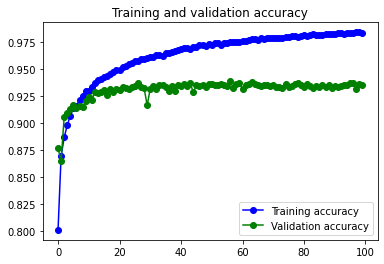

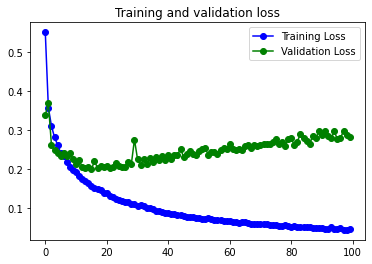

In [ ]:
plot_loss_acc(history3)

#Model with Big Dense Layer

In [ ]:
from tensorflow.python.ops.nn_ops import dropout
# Build the classification model
model4 = get_model(4)

model4.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
history4 = model4.fit(x_train, 
                        y_train, 
                        epochs=gEpochs, 
                        validation_data = (x_val, y_val), 
                        callbacks=callbacks)

Epoch 1/100
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4000 - accuracy: 0.8536 - val_loss: 0.3262 - val_accuracy: 0.8869
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2702 - accuracy: 0.9007 - val_loss: 0.3031 - val_accuracy: 0.8876
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2307 - accuracy: 0.9149 - val_loss: 0.3254 - val_accuracy: 0.8794
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1989 - accuracy: 0.9267 - val_loss: 0.2495 - val_accuracy: 0.9070
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1728 - accuracy: 0.9367 - val_loss: 0.2282 - val_accuracy: 0.9199
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1499 - accuracy: 0.9441 - val_loss: 0.2613 - val_accuracy: 0.9133
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1345 - accuracy: 0.9499 - val_loss: 0.2588 - va

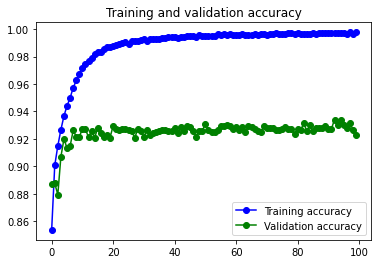

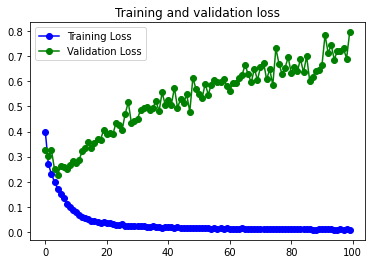

In [ ]:
plot_loss_acc(history4)

#Experiments

## Data augmentation
https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

x_trainr = x_train.reshape(-1, 28, 28, 1)
x_valr = x_val.reshape(-1, 28, 28, 1)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(x_trainr, y_train, batch_size=128)
test_gen = datagen.flow(x_valr, y_val, batch_size=128)

### Convolutional Model 

In [ ]:
modelDA1 = get_model(1)

modelDA1.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA1 = modelDA1.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 22s 46ms/step - loss: 0.8756 - accuracy: 0.6769 - val_loss: 0.6192 - val_accuracy: 0.7730
Epoch 2/100
469/469 [==============================] - 21s 45ms/step - loss: 0.6147 - accuracy: 0.7696 - val_loss: 0.5463 - val_accuracy: 0.8011
Epoch 3/100
469/469 [==============================] - 22s 46ms/step - loss: 0.5452 - accuracy: 0.7953 - val_loss: 0.5231 - val_accuracy: 0.8113
Epoch 4/100
469/469 [==============================] - 21s 45ms/step - loss: 0.4998 - accuracy: 0.8131 - val_loss: 0.4642 - val_accuracy: 0.8302
Epoch 5/100
469/469 [==============================] - 21s 45ms/step - loss: 0.4723 - accuracy: 0.8246 - val_loss: 0.4561 - val_accuracy: 0.8355
Epoch 6/100
469/469 [==============================] - 22s 46ms/step - loss: 0.4480 - accuracy: 0.8317 - val_loss: 0.4052 - val_accuracy: 0.8545
Epoch 7/100
469/469 [==============================] - 21s 45ms/step - loss: 0.4259 - accuracy: 0.8411 - val_loss: 0.4025 - val_ac

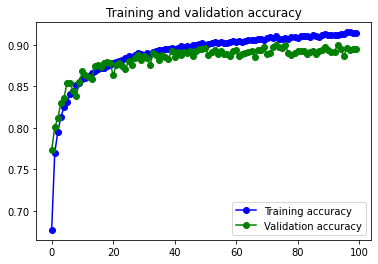

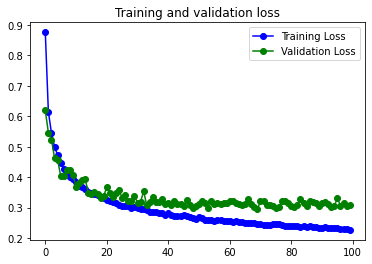

In [ ]:
plot_loss_acc(historyDA1)

###Convolutional model with dropout

In [ ]:
modelDA2 = get_model(2)

modelDA2.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA2 = modelDA2.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 23s 47ms/step - loss: 1.1228 - accuracy: 0.5778 - val_loss: 0.6943 - val_accuracy: 0.7389
Epoch 2/100
469/469 [==============================] - 22s 46ms/step - loss: 0.7744 - accuracy: 0.7131 - val_loss: 0.5990 - val_accuracy: 0.7664
Epoch 3/100
469/469 [==============================] - 22s 46ms/step - loss: 0.6904 - accuracy: 0.7421 - val_loss: 0.5702 - val_accuracy: 0.7744
Epoch 4/100
469/469 [==============================] - 21s 45ms/step - loss: 0.6431 - accuracy: 0.7573 - val_loss: 0.5279 - val_accuracy: 0.7971
Epoch 5/100
469/469 [==============================] - 22s 47ms/step - loss: 0.6125 - accuracy: 0.7739 - val_loss: 0.4906 - val_accuracy: 0.8183
Epoch 6/100
469/469 [==============================] - 23s 48ms/step - loss: 0.5871 - accuracy: 0.7840 - val_loss: 0.4656 - val_accuracy: 0.8286
Epoch 7/100
469/469 [==============================] - 21s 46ms/step - loss: 0.5676 - accuracy: 0.7922 - val_loss: 0.4526 - val_ac

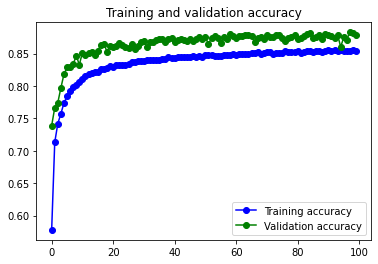

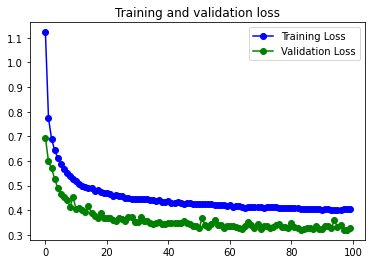

In [ ]:
plot_loss_acc(historyDA2)

###Convolutional Model Powered 1

In [ ]:
modelDA21 = get_model(21)

modelDA21.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA21 = modelDA21.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 23s 47ms/step - loss: 0.9425 - accuracy: 0.6448 - val_loss: 0.6144 - val_accuracy: 0.7645
Epoch 2/100
469/469 [==============================] - 21s 45ms/step - loss: 0.6559 - accuracy: 0.7536 - val_loss: 0.5328 - val_accuracy: 0.8096
Epoch 3/100
469/469 [==============================] - 23s 48ms/step - loss: 0.5886 - accuracy: 0.7807 - val_loss: 0.4642 - val_accuracy: 0.8256
Epoch 4/100
469/469 [==============================] - 21s 45ms/step - loss: 0.5393 - accuracy: 0.8009 - val_loss: 0.4221 - val_accuracy: 0.8465
Epoch 5/100
469/469 [==============================] - 21s 45ms/step - loss: 0.5109 - accuracy: 0.8098 - val_loss: 0.4147 - val_accuracy: 0.8483
Epoch 6/100
469/469 [==============================] - 22s 47ms/step - loss: 0.4882 - accuracy: 0.8185 - val_loss: 0.4050 - val_accuracy: 0.8460
Epoch 7/100
469/469 [==============================] - 21s 44ms/step - loss: 0.4704 - accuracy: 0.8255 - val_loss: 0.3847 - val_ac

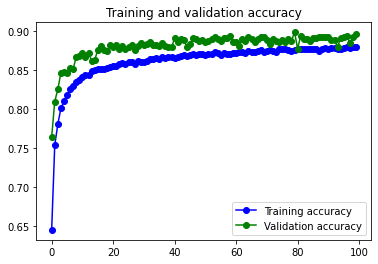

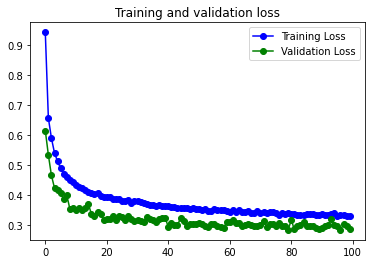

In [ ]:
plot_loss_acc(historyDA21)

###convolutional model powered 2


In [ ]:
modelDA22 = get_model(22)

modelDA22.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA22 = modelDA22.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 17s 35ms/step - loss: 0.7314 - accuracy: 0.7228 - val_loss: 0.9128 - val_accuracy: 0.6481
Epoch 2/100
469/469 [==============================] - 16s 34ms/step - loss: 0.5126 - accuracy: 0.8055 - val_loss: 0.4647 - val_accuracy: 0.8198
Epoch 3/100
469/469 [==============================] - 16s 34ms/step - loss: 0.4495 - accuracy: 0.8324 - val_loss: 0.4039 - val_accuracy: 0.8476
Epoch 4/100
469/469 [==============================] - 16s 34ms/step - loss: 0.4170 - accuracy: 0.8448 - val_loss: 0.3249 - val_accuracy: 0.8808
Epoch 5/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3865 - accuracy: 0.8567 - val_loss: 0.3158 - val_accuracy: 0.8828
Epoch 6/100
469/469 [==============================] - 16s 33ms/step - loss: 0.3693 - accuracy: 0.8631 - val_loss: 0.3037 - val_accuracy: 0.8895
Epoch 7/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3517 - accuracy: 0.8715 - val_loss: 0.3157 - val_ac

In [ ]:
plot_loss_acc(historyDA22)

###model with batch normalization

In [ ]:
modelDA3 = get_model(3)

modelDA3.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA3 = modelDA3.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 27s 53ms/step - loss: 0.8188 - accuracy: 0.7022 - val_loss: 0.6473 - val_accuracy: 0.7363
Epoch 2/100
469/469 [==============================] - 23s 49ms/step - loss: 0.5403 - accuracy: 0.7978 - val_loss: 0.4340 - val_accuracy: 0.8482
Epoch 3/100
469/469 [==============================] - 24s 50ms/step - loss: 0.4656 - accuracy: 0.8274 - val_loss: 0.4183 - val_accuracy: 0.8491
Epoch 4/100
469/469 [==============================] - 24s 52ms/step - loss: 0.4206 - accuracy: 0.8444 - val_loss: 0.3372 - val_accuracy: 0.8748
Epoch 5/100
469/469 [==============================] - 24s 51ms/step - loss: 0.3896 - accuracy: 0.8569 - val_loss: 0.3234 - val_accuracy: 0.8797
Epoch 6/100
469/469 [==============================] - 24s 51ms/step - loss: 0.3748 - accuracy: 0.8629 - val_loss: 0.3228 - val_accuracy: 0.8831
Epoch 7/100
469/469 [==============================] - 24s 50ms/step - loss: 0.3575 - accuracy: 0.8691 - val_loss: 0.3756 - val_ac

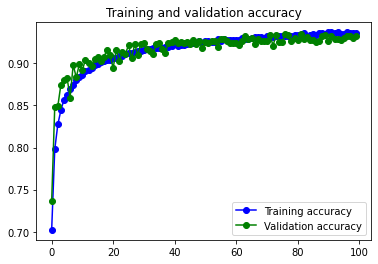

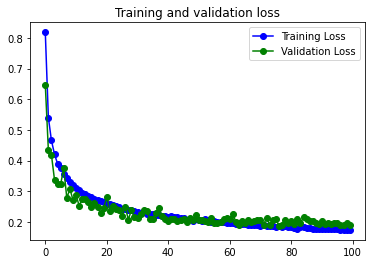

In [ ]:
plot_loss_acc(historyDA3)

### Model big Dense Layer

In [ ]:
modelDA4 = get_model(4)

modelDA4.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
historyDA4 = modelDA4.fit(train_gen, 
                        validation_data=(x_val, y_val), 
                        epochs=gEpochs, 
                        steps_per_epoch=len(train_gen), 
                        verbose=1
                        )

Epoch 1/100
469/469 [==============================] - 24s 48ms/step - loss: 0.5261 - accuracy: 0.7996 - val_loss: 0.9748 - val_accuracy: 0.6085
Epoch 2/100
469/469 [==============================] - 24s 50ms/step - loss: 0.3620 - accuracy: 0.8644 - val_loss: 0.3976 - val_accuracy: 0.8568
Epoch 3/100
469/469 [==============================] - 23s 48ms/step - loss: 0.3173 - accuracy: 0.8823 - val_loss: 0.3248 - val_accuracy: 0.8822
Epoch 4/100
469/469 [==============================] - 23s 48ms/step - loss: 0.2908 - accuracy: 0.8922 - val_loss: 0.3224 - val_accuracy: 0.8858
Epoch 5/100
469/469 [==============================] - 23s 49ms/step - loss: 0.2778 - accuracy: 0.8959 - val_loss: 0.2909 - val_accuracy: 0.8972
Epoch 6/100
469/469 [==============================] - 22s 47ms/step - loss: 0.2592 - accuracy: 0.9043 - val_loss: 0.2906 - val_accuracy: 0.8972
Epoch 7/100
469/469 [==============================] - 22s 47ms/step - loss: 0.2473 - accuracy: 0.9075 - val_loss: 0.2727 - val_ac

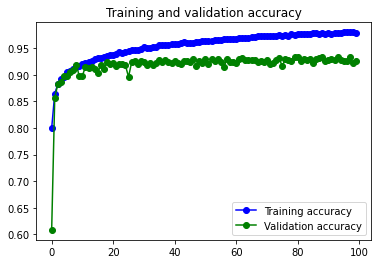

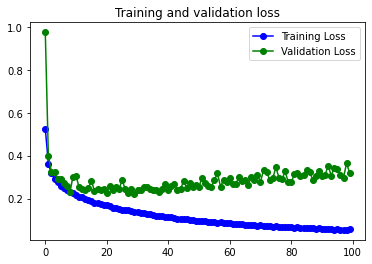

In [ ]:
plot_loss_acc(historyDA4)

##Improving the Convolutional Model with a custom Learning Rate 

In [ ]:
#based in the document https://www.jeremyjordan.me/nn-learning-rate/
#https://coderzcolumn.com/tutorials/artificial-intelligence/learning-rate-schedules-for-keras-networks#5
from tensorflow.keras.optimizers import Adam

modelr22 = get_model(22)


In [ ]:
# Set the learning rate scheduler
import numpy as np
#from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 *  10 ** (epoch / 30))

#lr_schedule = ExponentialDecay(0.1, decay_steps=500, decay_rate=0.58, staircase=True)


In [ ]:
#optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
optim=Adam()

modelr22.compile(optimizer=optim, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

historylr22 = modelr22.fit(x_train, 
                        y_train, 
                        epochs=100,
                        validation_data = (x_val, y_val), 
                        callbacks=[callbacks, lr_schedule])

Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5020 - accuracy: 0.8157 - val_loss: 0.3612 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3523 - accuracy: 0.8711 - val_loss: 0.3173 - val_accuracy: 0.8808 - lr: 0.0011
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3222 - accuracy: 0.8809 - val_loss: 0.3082 - val_accuracy: 0.8843 - lr: 0.0012
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2984 - accuracy: 0.8906 - val_loss: 0.2726 - val_accuracy: 0.9043 - lr: 0.0013
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2859 - accuracy: 0.8952 - val_loss: 0.2551 - val_accuracy: 0.9063 - lr: 0.0014
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2736 - accuracy: 0.8994 - val_loss: 0.2750 - val_accuracy: 0.8984 - lr: 0.0015
Epoch 7/100
1875/1875 [========================

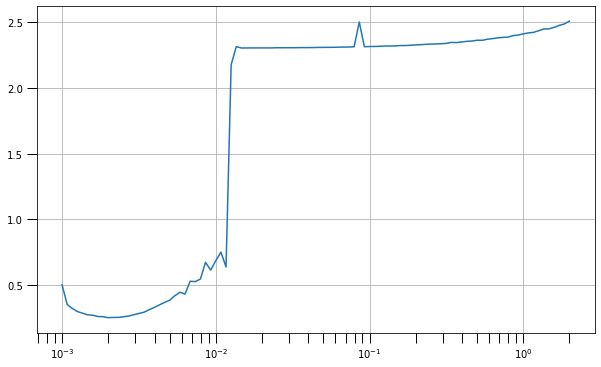

In [ ]:
# Define the learning rate array
lrs = 1e-3 * (10 ** (np.arange(100) / 30))
#1e-3 *  10 ** (epoch / 30))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, historylr22.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
#plt.axis([1e-8, 1e-3, -1, 5.10])

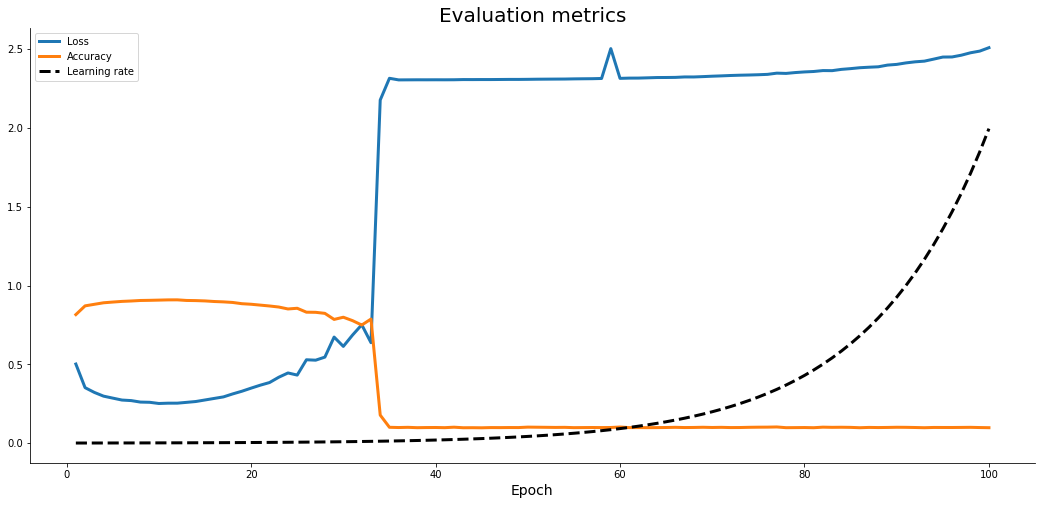

In [ ]:
plot_loss_acc_lr(historylr22)


In [ ]:
tf.keras.backend.clear_session()
modell = get_model(22)
modell.compile(optimizer=Adam(learning_rate=0.0017), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 

historyl = modell.fit(x_train, 
                        y_train, 
                        epochs=gEpochs,
                        validation_data = (x_val, y_val), 
                        callbacks=[callbacks])

Epoch 1/100
1875/1875 [==============================] - 11s 5ms/step - loss: 0.5287 - accuracy: 0.8065 - val_loss: 0.3528 - val_accuracy: 0.8744
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3700 - accuracy: 0.8654 - val_loss: 0.3563 - val_accuracy: 0.8692
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3302 - accuracy: 0.8783 - val_loss: 0.3818 - val_accuracy: 0.8503
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3070 - accuracy: 0.8873 - val_loss: 0.2999 - val_accuracy: 0.8914
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2911 - accuracy: 0.8949 - val_loss: 0.2648 - val_accuracy: 0.9045
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2736 - accuracy: 0.9007 - val_loss: 0.2642 - val_accuracy: 0.9041
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2682 - accuracy: 0.9018 - val_loss: 0.2368 - val

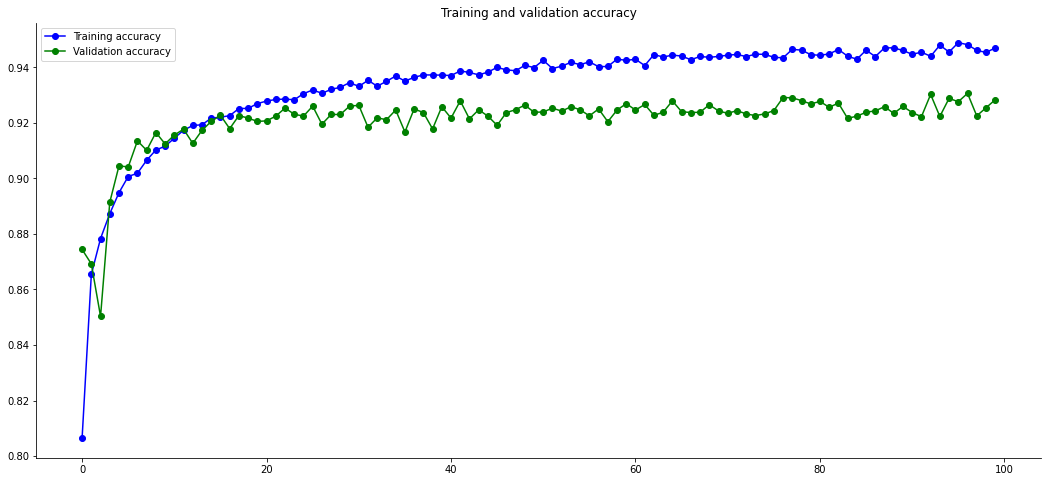

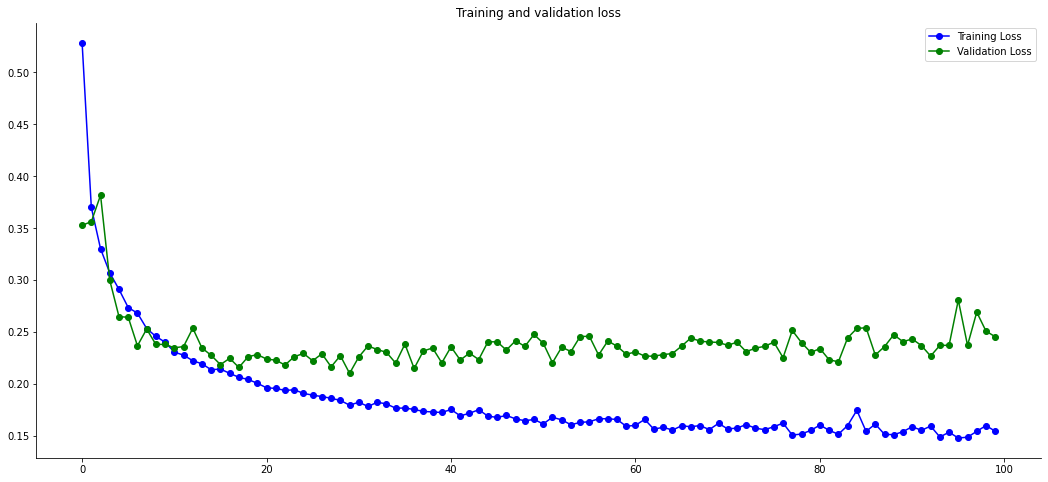

In [ ]:
plot_loss_acc(historyl)